In [1]:
!nvidia-smi

Sun Aug  9 17:15:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   28C    P8     6W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import dependencies

In [33]:
%load_ext autoreload
%autoreload 2

import os
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

import warnings

import utils
import torch_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 781
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Load data

In [4]:
%%time
pairs = [*zip(
    utils.read_file('./data/europarl-v7.fr-en.fr'),
    utils.read_file('./data/europarl-v7.fr-en.en')
)]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723
CPU times: user 3.42 s, sys: 1.01 s, total: 4.42 s
Wall time: 4.41 s


In [5]:
%%time
pairs = np.random.choice(pairs, size=200_000, replace=False)
pairs = [*map(
    lambda pair: {k: v for k, v in pair.items()}, # utils.normalize_string(v)
    pairs
)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples after sampling: 200,000
Example:
	FR => Les procédures par le biais desquelles de tels produits entrent et sortent de l'Union européenne doivent être ouvertes, transparentes et, par dessus tout, sûres.

	EN => The procedures whereby such products come in and out of the European Union have to be open, transparent and, above all, safe.

CPU times: user 1.29 s, sys: 49.1 ms, total: 1.34 s
Wall time: 1.34 s


## Build datasets

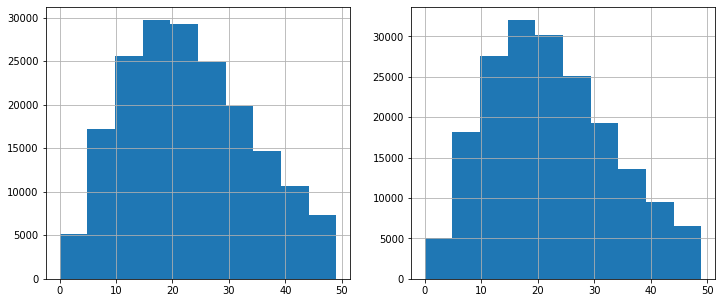

In [6]:
len_fr = [*map(lambda pair: len(pair['fr'].split()), pairs)]
len_en = [*map(lambda pair: len(pair['en'].split()), pairs)]

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist([*filter(lambda x: x < 50, len_fr)])
axes[0].grid(True)
axes[1].hist([*filter(lambda x: x < 50, len_en)])
axes[1].grid(True)
plt.show()

In [7]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True)
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en',
           include_lengths=True)

MIN_LENGTH, MAX_LENGTH = 20, 30

examples = [Example.fromdict(
    data=pair,
    fields={
        'fr': ('src', FR),
        'en': ('dest', EN)
    }
) for pair in tqdm.tqdm(pairs)]
examples = [*filter(
    lambda example: MIN_LENGTH <= len(example.src) and len(example.src) <= MAX_LENGTH \
        and MIN_LENGTH <= len(example.dest) and len(example.dest) <= MAX_LENGTH,
    examples
)]
print(f'Number of examples after filtering: {len(examples):,}')

100%|██████████| 200000/200000 [01:22<00:00, 2410.00it/s]


Number of examples after filtering: 39,389


In [8]:
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.8, 0.1, 0.1])
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 31,511
valid set size: 3,939
test set size: 3,939
{'src': ["d'", 'un', 'point', 'de', 'vue', 'psychologique', ',', 'la', 'destruction', 'des', 'infrastructures', 'critiques', 'entraîne', 'une', 'diminution', 'de', 'la', 'confiance', 'de', 'la', 'population', 'en', "l'", 'union', 'européenne', '.'], 'dest': ['from', 'a', 'psychological', 'point', 'of', 'view', ',', 'the', 'destruction', 'of', 'critical', 'infrastructures', 'leads', 'to', 'a', 'loss', 'of', 'public', 'confidence', 'in', 'the', 'european', 'union', '.']}


## Build vocabularies

In [9]:
MIN_COUNT = 5
FR.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 7,988
Length of EN vocabulary: 6,589


## Modeling

### Encoder model

In [10]:
class EncoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(EncoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            bidirectional=True,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
    
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, 2 * hidden_size]
            hn: Tensor[n_layers * 2, batch_size, hidden_size]
            cn: Tensor[n_layers * 2, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = self.dropout(embedded)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, (hn, cn) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs, hn, cn

In [11]:
def test_encoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        outputs, hn, cn = encoder(
            input_sequences=data.src[0],
            sequence_lengths=data.src[1]
        )
        seq_len = data.src[0].size(0)
        assert outputs.size() == torch.Size([seq_len, batch_size, 2 * 256]), outputs.size()
        assert hn.size() == torch.Size([4 * 2, batch_size, 256]), hn.size()
        assert cn.size() == torch.Size([4 * 2, batch_size, 256]), cn.size()
        break
    
test_encoder()

### Decoder model

In [12]:
class DecoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(DecoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_word_index, h_state, c_state):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        embedded = self.dropout(embedded)
        outputs, (h_state, c_state) = self.lstm(embedded, (h_state, c_state))
        logit = self.fc(outputs.squeeze(0))
        return logit, h_state, c_state

In [16]:
def test_decoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    decoder = DecoderLSTM(
        embedding_size=300,
        vocab_size=len(EN.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        logit, h_state, c_state = decoder(
            input_word_index=data.dest[0][0],
            h_state=torch.rand(4, batch_size, 256),
            c_state=torch.rand(4, batch_size, 256)
        )
        assert logit.size() == torch.Size([batch_size, len(EN.vocab)]), logit.size()
        assert h_state.size() == torch.Size([4, batch_size, 256]), h_state.size()
        assert c_state.size() == torch.Size([4, batch_size, 256]), c_state.size()
        break
        
test_decoder()

### Sequence-to-sequence model

In [21]:
class SeqToSeqLSTM(nn.Module):
    
    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, \
            'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, \
            'Encoder and Decoder must have the same number of reccurrent hidden units'
        
        super(SeqToSeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src_sequences, src_lengths, dest_sequences, dest_lengths, tf_ratio):
        """
        :params
            src_sequences: Tensor[seq_len, batch_size]
            src_lengths: Tensor[batch_size,]
            dest_sequences: Tensor[seq_len, batch_size]
            dest_lengths: Tensor[batch_size,]
            tf_ratio: float
            
        :return
            logits: Tensor[max(decode_lengths), batch_size, vocab_size]
            sorted_dest_sequences: Tensor[seq_len, batch_size]
            sorted_decode_lengths: Tensor[batch_size,]
            sorted_indices: Tensor[batch_size,]
        """
        # Encoding
        _, h_state, c_state = self.encoder(
            input_sequences=src_sequences,
            sequence_lengths=src_lengths
        )
        # h_state: [n_layers * 2, batch_size, hidden_size]
        # c_state: [n_layers * 2, batch_size, hidden_size]
        
        # Sort the batch (dest) by decreasing lengths
        sorted_dest_lengths, sorted_indices = torch.sort(dest_lengths, dim=0, descending=True)
        sorted_dest_sequences = dest_sequences[:, sorted_indices]
        
        # Init hidden and memory states
        h_state = h_state[:self.decoder.n_layers] \
            + h_state[self.decoder.n_layers:] # [n_layers, batch_size, hidden_size]
        c_state = c_state[:self.decoder.n_layers] \
            + c_state[self.decoder.n_layers:] # [n_layers, batch_size, hidden_size]
        
        # We won't decode at the <eos> position, since we've finished generating as soon as we generate <eos>
        # So, decoding lengths are actual lengths - 1
        sorted_decode_lengths = (sorted_dest_lengths - 1).tolist()
        
        # Decoding
        batch_size, last = h_state.size(1), None
        logits = torch.zeros(max(sorted_decode_lengths), batch_size, self.decoder.vocab_size).to(self.device)
        for t in range(max(sorted_decode_lengths)):
            batch_size_t = sum([l > t for l in sorted_decode_lengths])
            if last is not None:
                if random.random() < tf_ratio:
                    in_ = last[:batch_size_t]
                else:
                    in_ = sorted_dest_sequences[t, :batch_size_t]
            else:
                in_ = sorted_dest_sequences[t, :batch_size_t]
            # in_ [batch_size,]
            logit, h_state, c_state = self.decoder(
                in_, 
                h_state[:, :batch_size_t, :],
                c_state[:, :batch_size_t, :]
            )
            # logit: [batch_size, vocab_size]
            # h_state: [num_layers, batch_size, hidden_size]
            # c_state: [num_layers, batch_size, hidden_size]
            logits[t, :batch_size_t, :] = logit
            last = torch.argmax(F.softmax(logit, dim=1), dim=1) # [batch_size,]
        
        return logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices

In [27]:
def test_seq2seq():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    decoder = DecoderLSTM(
        embedding_size=300,
        vocab_size=len(EN.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    model = SeqToSeqLSTM(encoder, decoder, device='cpu')
    for data in train_iterator:
        logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
            model(
                src_sequences=data.src[0], 
                src_lengths=data.src[1],
                dest_sequences=data.dest[0],
                dest_lengths=data.dest[1],
                tf_ratio=0.
            )
        assert logits.size() == torch.Size([
            max(sorted_decode_lengths),
            batch_size,
            len(EN.vocab)
        ]), logits.size()
        assert sorted_dest_sequences.size() == torch.Size([
            data.dest[0].shape[0],
            batch_size
        ]), sorted_dest_sequences.size()
        assert len(sorted_decode_lengths) == batch_size, len(sorted_decode_lengths)
        assert sorted_indices.size() == torch.Size([
            batch_size,
        ]), sorted_indices.size()
        break
        
test_seq2seq()

### Training routines

In [34]:
def train_step(model, optimizer, criterion, loader, epoch, grad_clip, tf_ratio, device):
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.train()
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
    for i, data in pbar:
        # Forward prop.
        logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
            model(*data.src, *data.dest, tf_ratio=tf_ratio)
        # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
        sorted_dest_sequences = sorted_dest_sequences[1:, :]
        # Remove paddings
        logits = nn.utils.rnn.pack_padded_sequence(
            logits,
            sorted_decode_lengths
        ).data
        sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(
            sorted_dest_sequences,
            sorted_decode_lengths
        ).data
        # Calculate loss
        loss = criterion(logits, sorted_dest_sequences)
        # Back prop.
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients
        if grad_clip is not None:
            torch_utils.clip_gradient(optimizer, grad_clip)
        # Update weights
        optimizer.step()
        # Track metrics
        loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
        acc_tracker.update(
            torch_utils.accuracy(logits, sorted_dest_sequences, 5),
            sum(sorted_decode_lengths)
        )
        # Update progressbar description
        pbar.set_description(f'Epoch: {epoch + 1:03d} - loss: {loss_tracker.average:.3f} - acc: {acc_tracker.average:.3f}%')
    return loss_tracker.average, acc_tracker.average

In [35]:
def validate(model, criterion, loader, field, epoch, device):
    references, hypotheses = [], []
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar: 
            # Forward prop.
            logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
                model(*data.src, *data.dest, tf_ratio=tf_ratio)
            # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
            sorted_dest_sequences = sorted_dest_sequences[1:, :]
            # Remove paddings
            logits_copy = logits.clone()
            logits = nn.utils.rnn.pack_padded_sequence(
                logits,
                sorted_decode_lengths
            ).data
            # Calculate loss
            loss = criterion(logits, sorted_dest_sequences)
            # Track metrics
            loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
            acc_tracker.update(
                torch_utils.accuracy(logits, sorted_dest_sequences, 5),
                sum(sorted_decode_lengths)
            )
            # Update references
            target_sequences = data.dest[0][:, sorted_indices]
            for j in range(target_sequences.size(1)):
                target_sequence = target_sequences[:, j].tolist()
                reference = [
                    field.vocab.itos[indice] 
                    for indice in target_sequence 
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ]
                references.append([reference])
            # Update hypotheses
            _, preds = torch.max(logits_copy, dim=2)
            preds, temp_preds = preds.t().tolist(), []
            for j, p in enumerate(preds):
                temp_preds.append([*map(
                    lambda w: field.vocab.itos[w],
                    preds[j][:sorted_decode_lengths[j]])]) # Remove padding
                hypotheses.extend(temp_preds)
            # Update progressbar description
            pbar.set_description(f'Epoch: {epoch + 1:03d} - val_loss: {loss_tracker.average:.3f} - val_acc: {acc_tracker.average:.3f}%')
        # Calculate BLEU-4 score
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    return loss_tracker.average, acc_tracker.average, bleu4

In [36]:
def train(model, optimizer, criterion, train_loader, valid_loader, field, n_epochs, grad_clip, tf_ratio, device):
    history, best_bleu = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': [],
        'bleu4': []
    }, 0.
    for epoch in range(n_epochs):
         # Stop training if no improvment since last 4 epochs
        if last_improv == 4:
            print('Training Finished - The model has stopped improving since last 4 epochs')
            break
        # Decay LR if no improvment
        if last_improv > 0:
            torch_utils.adjust_lr(optimizer, 0.8)
        # Train step
        loss, acc = train_step(model=model,
                               optimizer=optimizer,
                               criterion=criterion,
                               loader=train_loader,
                               epoch=epoch,
                               grad_clip=grad_clip, 
                               tf_ratio=tf_ratio,
                               device=device)
        # Validation step
        val_loss, val_acc, bleu4 = validate(model=model,
                                            criterion=criterion,
                                            loader=valid_loader,
                                            field=field,
                                            epoch=epoch,
                                            device=device)
        # Update history dict
        history['acc'].append(acc)
        history['loss'].append(loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['bleu4'].append(bleu4)
        # Print BLEU score
        text = f'BLEU-4: {bleu4*100:.3f}%'
        if best_bleu > bleu4:
            last_improv += 1
            text += f' - Last improvement since {last_improv} epoch(s)'
        else:
            best_bleu, last_improv = bleu4, 0
        # Save checkpoint
        save_checkpoint(model=model,
                        optimizer=optimizer,
                        data_name=model_name,
                        epoch=epoch,
                        last_improv=last_improv,
                        bleu4=bleu4,
                        is_best=bleu4 >= best_bleu)
    return history

### Init models

In [37]:
MODEL_NAME = 'seq2seq-lstm'
HIDDEN_SIZE = 256
EMBEDDING_SIZE = 300
DROPOUT = 0.25

In [ ]:
N_EPOCHS = 15
BATCH_SIZE = 128
LEARNING_RATE = 3e-5
GRAD_CLIP = 5.
TF_RATIO = 0.

### Training

### Evaluation

### Inference